# Predicting Flight Delays

The ogjective of this project is to use historical flight information to create a classification model that can return the probability of a flight being delayed. 

We will be looking at data from 2016, 2017, and 2018. All data files are downloaded from OST website, which stores flights on-time performance fro 1987 to present.

**Our MVP**: Our MVP will look to just deliver predictions and exploration on the flight data. Once the MVP is completed, I will look to bring in weather data.


In addition to the data that we are bringing, we will also be using weather data. 

As stated in a published paper by 

> "Our analysis shows that weather shocks like rainfall, snow and wind have a significant impact on departure delays within the U.S. aviation system. Depending on the intensity of the weather shock considered, rain- and snowfall lead to additional departure delays between 10 and 23 min. For wind, the discovered effects are smaller in magnitude, ranging from 1 to 3 min. While the impact of rainfall is more pronounced between April and September, the effect of wind is more evenly distributed across the year. With regard to slow onset weather shocks, our results reveal that cold conditions lead to additional departure delays. For temperatures below 0∘C, our analysis shows an increase in delay on average by around 2 min per departure. For heat, we do not discover any significant amplifying impacts on departure delay. While our results indicate a tendency of higher average departure delays when temperatures go beyond 45∘C, the results are not statistically significant. Considering the recent experiences from Phoenix, where temperatures of 49∘C on June 20th, 2017 lead to the cancellation of more than 40 regional flights, together with the projections by Coffel et al. (2017), we expect extreme temperatures to increase departure delays.8 Our observations for temperatures beyond 45∘C, however, are insufficient for robust estimates."$^1$



$^1$Borsky, S and Unterberger, C (2019) ‘Bad weather and flight delays: The impact of sudden and slow onset weather events’, Economics of Transportation, Volume 18.

The weather data comes from:

Moosavi, Sobhan, Mohammad Hossein Samavatian, Arnab Nandi, Srinivasan Parthasarathy, and Rajiv Ramnath. “Short and Long-term Pattern Discovery Over Large-Scale Geo-Spatiotemporal Data.” In Proceedings of the 25th ACM SIGKDD International Conference on Knowledge Discovery & Data Mining, ACM, 2019.

In [174]:
import pandas as pd
import numpy as np

import os.path
import requests
import io

import seaborn as sns
import matplotlib.pyplot as plt

# Acquistion

In [21]:
# df = pd.read_csv("https://raw.githubusercontent.com/michaelarg/datasets/master/airports.csv")

# airports = df[df.Country == "United States"]

# weather_data = pd.read_csv("US_WeatherEvents_2016-2019.csv")

In [115]:
df = pd.read_csv("2018.csv")

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7213446 entries, 0 to 7213445
Data columns (total 28 columns):
FL_DATE                object
OP_CARRIER             object
OP_CARRIER_FL_NUM      int64
ORIGIN                 object
DEST                   object
CRS_DEP_TIME           int64
DEP_TIME               float64
DEP_DELAY              float64
TAXI_OUT               float64
WHEELS_OFF             float64
WHEELS_ON              float64
TAXI_IN                float64
CRS_ARR_TIME           int64
ARR_TIME               float64
ARR_DELAY              float64
CANCELLED              float64
CANCELLATION_CODE      object
DIVERTED               float64
CRS_ELAPSED_TIME       float64
ACTUAL_ELAPSED_TIME    float64
AIR_TIME               float64
DISTANCE               float64
CARRIER_DELAY          float64
WEATHER_DELAY          float64
NAS_DELAY              float64
SECURITY_DELAY         float64
LATE_AIRCRAFT_DELAY    float64
Unnamed: 27            float64
dtypes: float64(20), int64(3),

Given that there is a large amount of data (+1.5GB), we will filter down to the top 15 largest airports. This will be at least for the exploration phase. We may look to bring additional data once we are ready to model

In [117]:
top_airports = ["ATL", "LAX", "ORD", "DFW", "DEN", "JFK", "SFO", "SEA", "LAS", "MCO", "EWR", "CLT", "PHX", "IAH", "MIA"]

In [119]:
for i in top_airports:
    df.loc[df['ORIGIN'] == i, 'is_top'] = True 
    

In [121]:
df.is_top = df.is_top.fillna(False)

In [122]:
df[df.is_top].ORIGIN.value_counts()

ATL    390046
ORD    332953
DFW    279298
DEN    235989
CLT    233317
LAX    221486
SFO    175849
PHX    173962
IAH    173806
LAS    161113
EWR    143875
SEA    140006
MCO    138296
JFK    129684
MIA     87880
Name: ORIGIN, dtype: int64

In [123]:
df = df[df.is_top]

In [124]:
df.shape

(3017560, 29)

In [125]:
df.isnull().sum()

FL_DATE                      0
OP_CARRIER                   0
OP_CARRIER_FL_NUM            0
ORIGIN                       0
DEST                         0
CRS_DEP_TIME                 0
DEP_TIME                 40437
DEP_DELAY                41790
TAXI_OUT                 41892
WHEELS_OFF               41892
WHEELS_ON                43585
TAXI_IN                  43585
CRS_ARR_TIME                 0
ARR_TIME                 43585
ARR_DELAY                50550
CANCELLED                    0
CANCELLATION_CODE      2975227
DIVERTED                     0
CRS_ELAPSED_TIME             2
ACTUAL_ELAPSED_TIME      49843
AIR_TIME                 49843
DISTANCE                     0
CARRIER_DELAY          2416987
WEATHER_DELAY          2416987
NAS_DELAY              2416987
SECURITY_DELAY         2416987
LATE_AIRCRAFT_DELAY    2416987
Unnamed: 27            3017560
is_top                       0
dtype: int64

In [130]:
df[df.WEATHER_DELAY.isnull()].ARR_DELAY.mean()

-8.56143138397515

We see that even after only keeping the top 15 airports, we stll have a lot of NULL values. We find that actually the null values are for when the flight did not experienced any delays. We will impude all these values with 0.0.

We see that we largely were able to get rid of any null values. It seems that `Cancelation_code` has no remaining values, we so will drop that column. Additionally, it seems that `Dep_delay` still has some null values, so we will try to impude those.

In [131]:
df.drop(columns = ["Unnamed: 27", "is_top", "CANCELLATION_CODE"], inplace=True)

In [143]:
df = df[df.ARR_DELAY.notnull()]

In [145]:
df = df[df.DEP_DELAY.notnull()]

In [148]:
df = df.fillna(0.0)

In [150]:
df.isnull().sum()

FL_DATE                0
OP_CARRIER             0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
CANCELLED              0
DIVERTED               0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
dtype: int64

In [152]:
df.columns = map(str.lower, df.columns)

In [200]:
# lets add the airline names

airline_code = pd.read_csv("airline_codes.csv")

airline_code.drop(columns="Unnamed: 0", inplace=True)

In [208]:
df = df.merge(airline_code, how="left", left_on="op_carrier", right_on = "Code")

In [212]:
df.drop(columns="Code", inplace=True)

Now that we have the data in the shape that we want it it, we are ready to move onto exploration

# Exploration

We will look to understand if there are any patterns that can help us predict if a flight will be delayed.

## What percentage of flights experience delays?

In [159]:
print(f"{(df.arr_delay > 0).mean():.0%} of flights experienced a delay in 2018")

37% of flights experienced a delay in 2018


## What airline carrier experiences the most delays?

Text(0.5, 0, 'Airline Code')

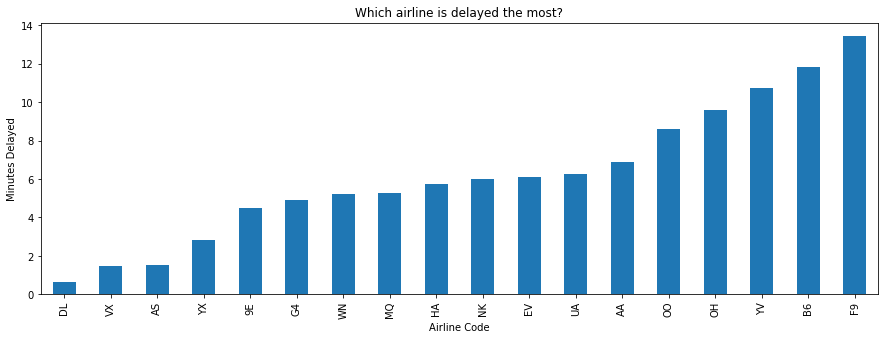

In [209]:
# Delays in minutes
df.groupby("op_carrier").arr_delay.mean().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airline is delayed the most?")
plt.ylabel("Minutes Delayed")
plt.xlabel("Airline Code")

It seems that Frontier had the longest delays, with an average of 13 min delay across 2018. Delta had the overall smallest delays in minutes, with an average of 0.6 min for 2018

Text(0.5, 0, 'Airline Code')

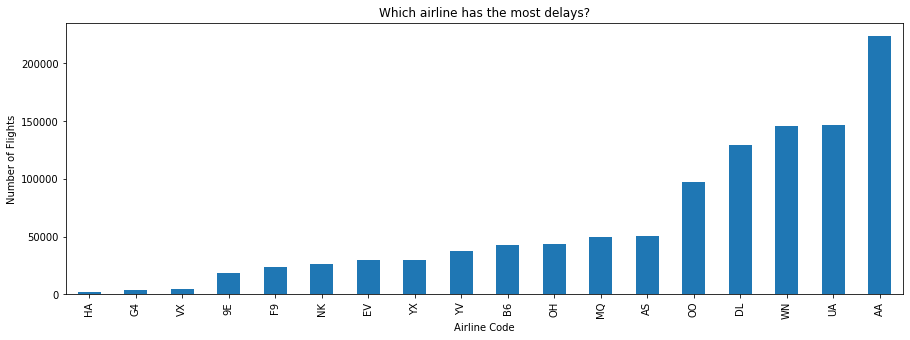

In [210]:
# Delays by flights (count)

df[df.arr_delay > 0].groupby("op_carrier").arr_delay.count().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airline has the most delays?")
plt.ylabel("Number of Flights")
plt.xlabel("Airline Code")

Interestingly, American Airlines seems to have the most flights delayed. I think this is more indicative of which airlines have most scheduled flights. If we want to look at better metric of delays, we should use minutes delayed.

## What airport experience the most delays?

Text(0.5, 0, 'Airline Code')

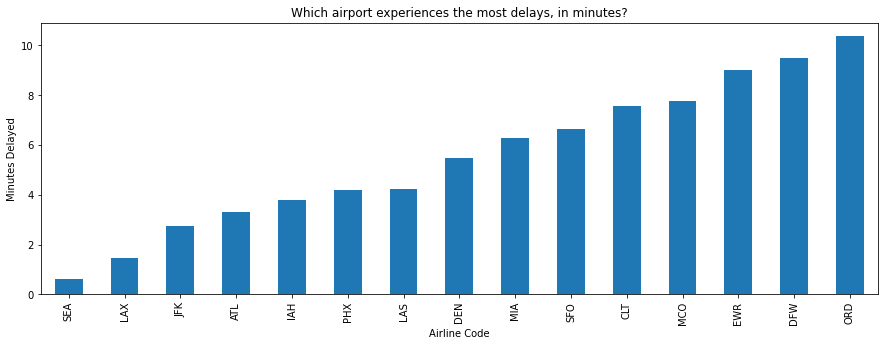

In [185]:
# Delays in minutes
df.groupby("origin").arr_delay.mean().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airport experiences the most delays, in minutes?")
plt.ylabel("Minutes Delayed")
plt.xlabel("Airline Code")

Text(0.5, 0, 'Airline Code')

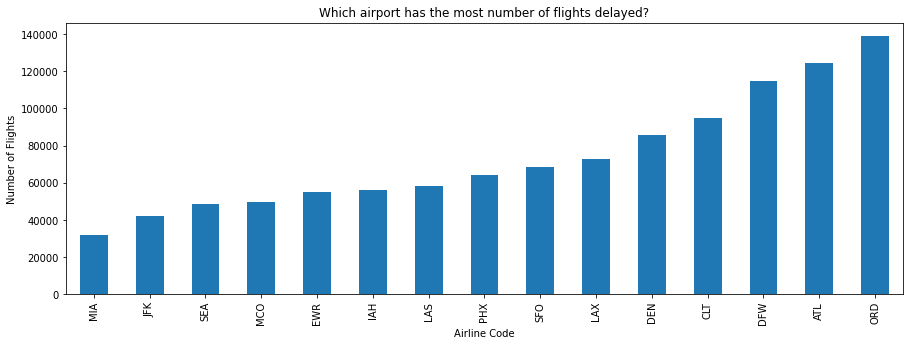

In [188]:
df[df.arr_delay > 0].groupby("origin").arr_delay.count().sort_values().plot.bar(figsize=(15,5))
plt.title("Which airport has the most number of flights delayed?")
plt.ylabel("Number of Flights")
plt.xlabel("Airline Code")

Interestingly, Orland seems to have the most delays both in number of flights delayed by more than a minute, and avg minutes delayed. Some ideas that might help explain these results:

1. Look at airports that recieve the most international flights
1. Look at what airports have hubs for what airlines. Given that we know that overall some airlines have a higher propensity to experience delays, it might be that this has an effect on delays by airports.

I initially though that weather might have an impact on this - as Orlando could experience high humidity, however Miami is on the other side of the spectrum, and I would suspect they would have similar weather.

We know Atlanta and LAX are the busiest airports in terms of total number of flights.

## What is the most common type of delay?

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2965760 entries, 0 to 2965759
Data columns (total 27 columns):
fl_date                object
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
cancelled              float64
diverted               float64
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
dtypes: float64(19), int64(3), object(5)
memory usage: 633.6+

Text(0.5, 0, 'Reason for delay')

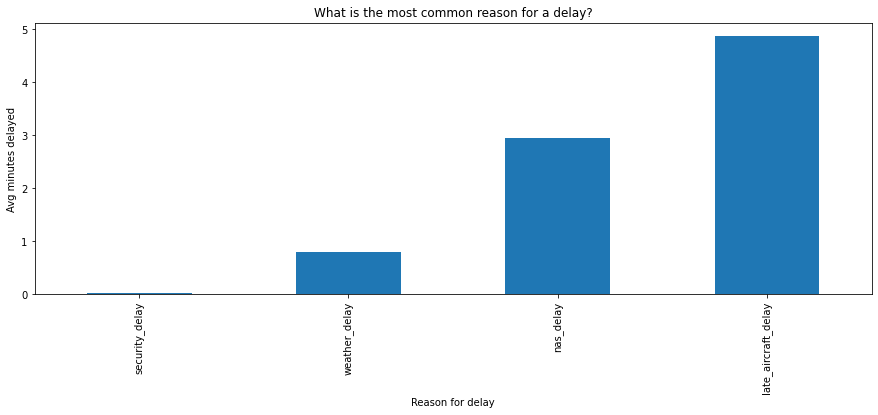

In [223]:
df.iloc[:,22:26].mean().sort_values().plot.bar(figsize=(15,5))
plt.title("What is the most common reason for a delay?")
plt.ylabel("Avg minutes delayed")
plt.xlabel("Reason for delay")

It seems that a late aircraft arrival is the main cause for delays. This raises more questions, as now we may have to not only look at the weather and factor of the previous flights (which means we will need to definitively look at the flight number). 

We might be able to use this information to track inbound [flights]https://flightaware.com/live/flight/UAL208/history/20200709/2205Z/KATL/KIAH

If we could find a way to actually scrape the previous airport, we might be able to get additional data to enhance the model's effectiveness.

## Are delays more or less common when the destination is another major airport?

In [230]:
for i in top_airports:
    df.loc[df['dest'] == i, 'is_top'] = True
    
df.is_top = df.is_top.fillna(False)

In [232]:
df[df.is_top].arr_delay.mean()

5.972897744384738

In [234]:
df[~df.is_top].arr_delay.mean()

5.636822310970039

We see that there is actually very little difference in avg delay in minutes based on the airport destination.

## Is there a time series element to delays?

Elements to look for:

* Yearly seasonality
* Month
* Day of week
* Hourly

In [245]:
df.fl_date = pd.to_datetime(df.fl_date)

In [246]:
df = df.set_index("fl_date")

In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2965760 entries, 2018-01-01 to 2018-12-31
Data columns (total 27 columns):
op_carrier             object
op_carrier_fl_num      int64
origin                 object
dest                   object
crs_dep_time           int64
dep_time               float64
dep_delay              float64
taxi_out               float64
wheels_off             float64
wheels_on              float64
taxi_in                float64
crs_arr_time           int64
arr_time               float64
arr_delay              float64
cancelled              float64
diverted               float64
crs_elapsed_time       float64
actual_elapsed_time    float64
air_time               float64
distance               float64
carrier_delay          float64
weather_delay          float64
nas_delay              float64
security_delay         float64
late_aircraft_delay    float64
Airline                object
is_top                 bool
dtypes: bool(1), float64(19), int64(3), object(4

In [250]:
monthly = df.resample("M").mean()

Text(0.5, 0, 'Date')

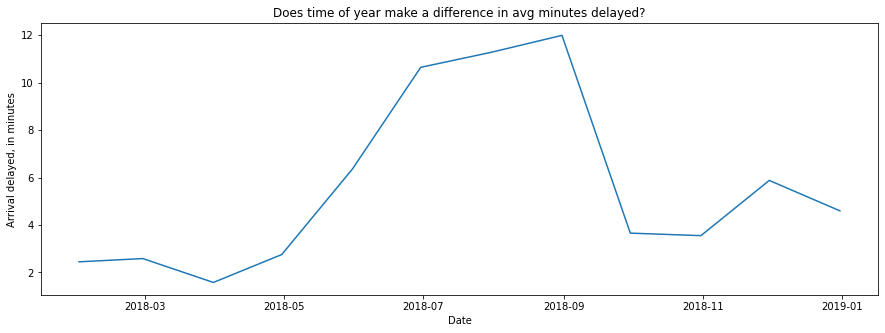

In [252]:
plt.figure(figsize=(15,5))
sns.lineplot(data=monthly, x=monthly.index, y="arr_delay")
plt.title("Does time of year make a difference in avg minutes delayed?")
plt.ylabel("Arrival delayed, in minutes")
plt.xlabel("Date")

We see that there ceirtainly seems to be a seasonality that could be impacting flight delays. It seems that over the summer is when delayes peak. This is likely related to an increase in travel from school breaks as well as summer holidays. We do see a small spike in December, which likely shows people traveling for Christmas. 

In [293]:
# Is there a difference in day of the week delay?

pd.concat([df,df.reset_index().fl_date.dt.day_name()], axis=1)

,op_carrier,op_carrier_fl_num,origin,dest,crs_dep_time,dep_time,dep_delay,taxi_out,wheels_off,wheels_on,...,air_time,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,Airline,is_top,day_of_week
fl_date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,UA,2429,EWR,DEN,1517,1512.0,-5.0,15.0,1527.0,1712.0,...,225.0,1605.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,NaN
2018-01-01,UA,2427,LAS,SFO,1115,1107.0,-8.0,11.0,1118.0,1223.0,...,65.0,414.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,NaN
2018-01-01,UA,2424,ORD,ALB,630,650.0,20.0,13.0,703.0,926.0,...,83.0,723.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,False,NaN
2018-01-01,UA,2422,ORD,OMA,2241,2244.0,3.0,15.0,2259.0,1.0,...,62.0,416.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,False,NaN
2018-01-01,UA,2421,IAH,LAS,750,747.0,-3.0,14.0,801.0,854.0,...,173.0,1222.0,0.0,0.0,0.0,0.0,0.0,United Air Lines Inc.,True,NaN


In [294]:
df = df.reset_index()

In [296]:
df["day_name"] = df.fl_date.dt.day_name()

Text(0, 0.5, 'Arrival delay, in minutes')

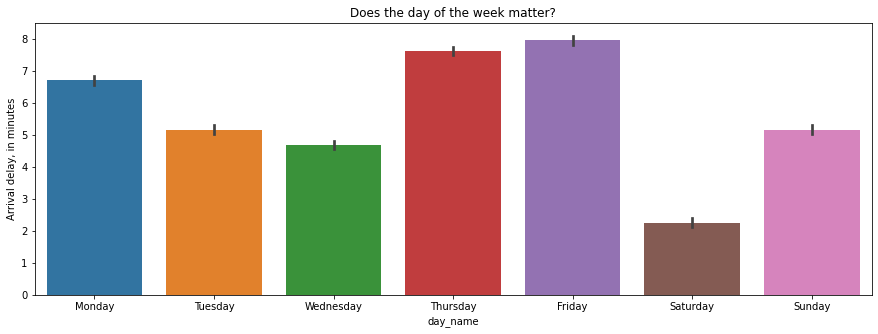

In [299]:
plt.figure(figsize=(15,5))
sns.barplot(data=df, x="day_name", y="arr_delay")
plt.title("Does the day of the week matter?")
plt.ylabel("Arrival delay, in minutes")

It seems that there is ceirtainly some big difference, with Saturday experiencing the least number of delays, and Thursday and Friday having the most. This kind of makes sense, as you would expect most people to travel on a Thursday or Friday (to take advantage of the long weekends) and then return Sunday. Satuday is likely on of the least traveled days.

In [307]:
df["crs_dep_time"] = df['crs_dep_time'].astype(str).apply(lambda x: x.zfill(4))

In [321]:
# By time of day?

pd.to_datetime(df.crs_dep_time, format= "%H%M")

0         1900-01-01 15:17:00
1         1900-01-01 11:15:00
2         1900-01-01 06:30:00
3         1900-01-01 22:41:00
4         1900-01-01 07:50:00
                  ...        
2965755   1900-01-01 19:55:00
2965756   1900-01-01 13:21:00
2965757   1900-01-01 17:51:00
2965758   1900-01-01 20:15:00
2965759   1900-01-01 13:00:00
Name: crs_dep_time, Length: 2965760, dtype: datetime64[ns]

In [304]:
df.crs_dep_time

0          1517
1          1115
2           630
3          2241
4           750
           ... 
2965755    1955
2965756    1321
2965757    1751
2965758    2015
2965759    1300
Name: crs_dep_time, Length: 2965760, dtype: int64